# Recurrent Neural Networks

Feed-forward neural networks are designed to accept inputs of constant lengths through their input layer neurons. This can be a strong limitation, especially when processing language data such as sequences of words or characters, most of which may differ substantially in terms of length.

One way of reducing an arbitrary number of input vectors to a fixed size input is by employing the _continuous bag of words_ representation, which simply computes the average of the inputs' vector representations $v(f_i)$:
\begin{equation}
	CBOW(f_1, ..., f_k) = \frac{1}{k} \sum_{i=1}^{k} v(f_i)
\end{equation}
Optionally, each input can be assigned an individual weight $a_i$:
\begin{equation}
	WCBOW(f_1, ..., f_k) = \frac{1}{\sum_{i=1}^{k} a_i} \sum_{i=1}^{k} a_i v(f_i)
\end{equation}
The main disadvantage of this approach lies in the fact that the order of inputs is not taken into account. For language processing tasks, this information can be crucial, e.g. to predict the next element in a sequence.

_Recurrent neural networks_ (RNNs) address the problem of dealing with input sequences of arbitrary lengths by introducing _states_ and _time steps_. At time $t$, $s_t$ denotes the internal state vector of the model. Upon receiving a new input, the state is updated, taking both the old state $s_{t-1}$ and the new input $x_t$ into account:
\begin{equation}
	s_t = R(s_{t-1}, x_t)
\end{equation}
At every time step, the network also produces an output vector $y_t$ depending on its current state, i.e.
\begin{equation}
	y_t = O(s_t).
\end{equation}
The following figure shows the RNN architecture in comparison to the feed-forward architecture:

Feed-forward neural network | Recurrent neural network
:-: | :-:
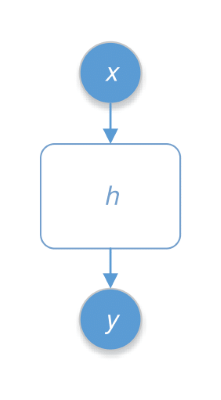 | 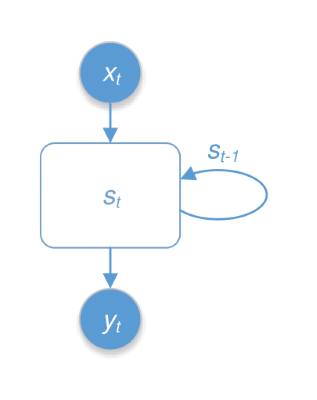

> A comparison of feed-forward and recurrent neural networks. The feed-forward network transforms inputs $x$ into outputs $y$ using a number of hidden layers $h$. The RNN accepts sequences of inputs; at every time step, it receives an input  $x_t$ and calculates an output $y_t$, taking its current state $s_t$ and previous state $s_{t-1}$ into account.

The original implementation of RNNs is very similar to a feed-forward network with one hidden layer; the only difference is the addition of the previous state vector weighted by a matrix:
\begin{equation}
	s_t = g(x_t W_1 + s_{t-1} W_2 + b)
\end{equation}
The output vector is equal to the state of the model:
\begin{equation}
	y_t = s_t
\end{equation}
Thus, for an example sequence $(x_1, x_2, x_3)$ and some initial state $s_0$, the final state $s_3$ can be calculated as
\begin{equation}
	s_3 = g(x_3 W_1 + g(x_2 W_1 + g(x_1 W_1 + s_0 W_2 + b) W_2 + b) W_2 + b).
\end{equation}

A modified version of the backpropagation algorithm called _backpropagation through time_ is used to train RNNs. Unlike standard backpropagation, it uses a computation graph that contains multiple time steps of the model and is usually applied after a complete sequence has been fed into the network. The process of creating the computation graph is called _unrolling_ the recurrent network and is shown in the Figure below.

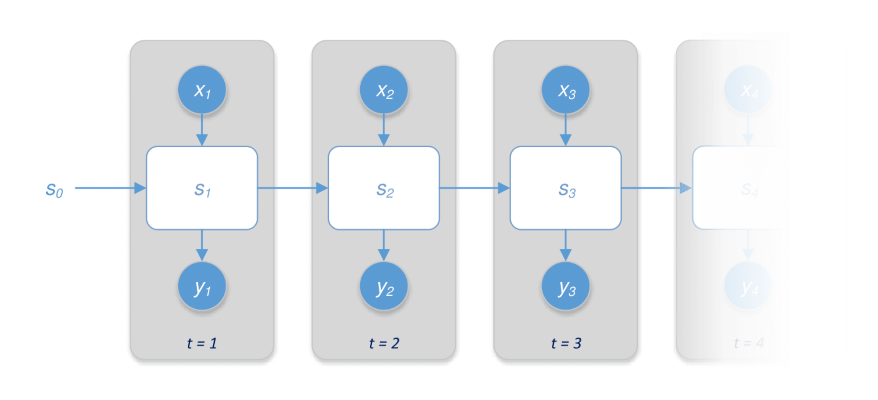

> A visualization of multiple time steps of an RNN. At every time step, the internal state $s_t$ is updated after receiving an input $x_t$. This adds additional nodes to the corresponding computation graph. Thus, the number of operations in the computation graph depends on the length of the sequence, i.e. the number of inputs.

Since unrolled RNNs can become very deep depending on the sequence length, they often suffer from _vanishing_ or _exploding gradients_, where the gradients become either very small or very large resulting in poor training and overall performance. While exploding gradients can be dealt with by introducing an upper limit and clipping the gradients exceeding it, no such simple solution exists for vanishing gradients. When a network is trained using sequences, a vanishing error gradient can prevent the model from learning long-term dependencies. As a result modifications to the original RNN architecture have been developed with the objective of counteracting the vanishing gradient problem.

The _long short-term memory_ (LSTM) architecture introduces _memory cells_ and _gates_ to preserve gradients even when long sequences are processed. A gate is a vector composed of elements in $[0, 1]$. When a gate is multiplied element-wise with another vector, its components may or may not pass the gate, depending on the corresponding values.

Concretely, there are three gates $i$, $f$ and $o$ controlling _input_, _forget_ and _output_ based on the current input $x_t$ and previous state $s_{t-1}$:
\begin{gather}
	i = \sigma(x_t W_{xi} + s_{t-1} W_{si}) \\
	f = \sigma(x_t W_{xf} + s_{t-1} W_{sf}) \\
	o = \sigma(x_t W_{xo} + s_{t-1} W_{so})
\end{gather}
At every time step, the memory cell $c_t$ keeps some of its previous values $c_{t-1}$ in addition to the new values, which are calculated as a linear combination of the network inputs and the previous state and passed through a tanh activation function:
\begin{equation}
	c_t = c_{t-1} \odot f + \tanh(x_t W_x + s_{t-1} W_s) \odot i
\end{equation}
The forget gate $f$ and input gate $i$ control the degree to which the respective values are kept through the element-wise multiplication of two vectors denoted by $\odot$. Finally, the new state is controlled by the output gate $o$:
\begin{equation}
	s_t = \tanh(c_t) \odot o
\end{equation}
Similarly to the original RNN architecture, the output $y_t$ is equal to the current state:
\begin{equation}
	y_t = s_t
\end{equation}
The following figure illustrates the data flow in an LSTM cell:

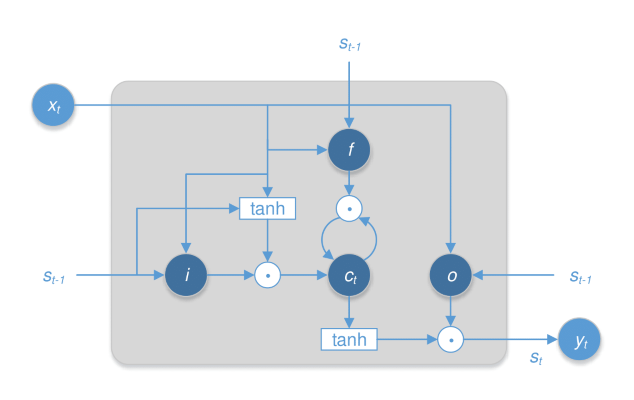

> The interaction of the gates and the memory cell in the LSTM architecture. The gates $i$, $f$ and $o$ control the memory cell $c_t$ and the state $s_t$ depending on the current input $x_t$ and the previous state $s_{t-1}$.

## Example: Counting Ones

We will now implement an example LSTM model with keras. Our model should accept as input a sequence of zeros and ones and output the number of ones in the sequence. Some examples are:

\begin{align}
    11101 &\mapsto 4\\
    1010 &\mapsto 2\\
    001 &\mapsto 1
\end{align}

This is a so-called _many-to-one_ RNN as it processes a sequence of an abitrary number of inputs, but only outputs a single result (instead of another sequence). In practice, when we train and use our model, we feed it the whole input sequence and simply ignore every output except the last one.

In [1]:
import numpy
from tensorflow import keras

Before we build our model, we have to generate some training and test data first. The following function generates a batch of $(x, y)$ pairs, where $x$ is a random sequence of zeros and ones and $y$ is the number of ones in the sequence. The parameters of the function determine the size of the batch and length of the sequences. Note that we reshape $x$ and $y$ so that every RNN input $x_t$ as well as every final output $y$ is a vector (in this case $1$-dimensional).

In [2]:
def generate_batch(batch_size, seq_length):
    b_x, b_y = [], []    
    for _ in range(batch_size):
        # the sequence itself
        x = numpy.random.randint(2, size=seq_length)
        # the result (number of ones)
        y = numpy.sum(x)
        # reshape x and y to get 1-dimensional vectors
        b_x.append(x.reshape(seq_length, 1))
        b_y.append([y])
    return numpy.asarray(b_x), numpy.asarray(b_y)

b_x, b_y = generate_batch(5, 10)
print('shape of b_x: {}, shape of b_y: {}'.format(b_x.shape, b_y.shape))
for x, y in zip(b_x, b_y):
    print('{}\t{}'.format(x.flatten(), y))

shape of b_x: (5, 10, 1), shape of b_y: (5, 1)
[1 0 1 0 0 1 1 0 1 1]	[6]
[0 1 1 0 1 0 0 1 0 1]	[5]
[1 0 1 1 0 0 1 0 0 1]	[5]
[1 1 1 1 0 0 1 0 1 1]	[7]
[0 0 0 0 1 1 1 1 1 1]	[6]


Now we can use keras to build a very simple LSTM model. It consists of
 - An input layer with a single input neuron
 - An LSTM layer with $64$ hidden neurons
 - A dense (fully-connected) output layer to transform the LSTM output to a $1$-dimensional vector

In [3]:
model = keras.Sequential()
model.add(keras.layers.InputLayer(input_shape=(None, 1)))
model.add(keras.layers.LSTM(64, return_sequences=False))
model.add(keras.layers.Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='sgd')

Note that the `input_shape` argument is used to determine the number of input neurons and the batch size. In our case, we set the batch size to `None` which makes keras automatically infer the missing value. The `return_sequences` parameter determines whether the LSTM returns all outputs or just the last one. In our dense layer we choose a linear activation, because we want to predict an arbitrarily large number (if we used a sigmoid or tanh activation here we would always end up with a number in $[0, 1]$). Finally, we use $L_2$ (mean squared error) loss and stochastic gradient descent optimization.

To train our model we will make use of Keras' `fit_generator` function. It expects a generator that yields batches of training data. Our batch generator simply yields randomly generated batches using the function we implement earlier. In this example we use a batch size of $32$ and generate sequences that are between $2$ and $20$ numbers long. We specify that keras should train $20$ epochs with $1000$ batches each, printing the loss after every epoch.

In [4]:
def batch_generator(batch_size, len_min, len_max):
    while True:
        seq_len = numpy.random.randint(len_min, len_max)
        yield generate_batch(batch_size, seq_len)

generator = batch_generator(32, 2, 20)
model.fit_generator(generator, steps_per_epoch=1000, epochs=5, shuffle=False)

Epoch 1/5
1000/1000 [==============================] - 21s 21ms/step - loss: 1.3774
Epoch 2/5
1000/1000 [==============================] - 19s 19ms/step - loss: 0.3426
Epoch 3/5
1000/1000 [==============================] - 19s 19ms/step - loss: 0.2167
Epoch 4/5
1000/1000 [==============================] - 19s 19ms/step - loss: 0.0986
Epoch 5/5
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1126


With our model trained now, we can test it out with some example sequences:

In [5]:
seqs = [[[0], [1], [1], [0], [1], [0]],    # 3
        [[1], [1], [1], [0], [1], [1]],    # 5
        [[0], [0], [0], [0], [0], [0]]]    # 0
model.predict(numpy.asarray(seqs))

array([[3.0067725 ],
       [5.29214   ],
       [0.00541937]], dtype=float32)

We can also use keras' `evaluate_generator` function to evaluate the model, which returns the loss on the test instances:

In [6]:
test_generator = batch_generator(32, 2, 20)
model.evaluate_generator(test_generator, steps=100)

0.06400348982773721

Evaluating the model with sequences that are longer than any of the training sequences shows the weakness of this approach:

In [7]:
test_generator = batch_generator(32, 20, 30)
model.evaluate_generator(test_generator, steps=100)

3.199679480344057